In [1]:
import pandas as pd
import requests
import json
import os
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from operator import attrgetter
from datetime import datetime, timedelta
from pymongo import MongoClient
from bson.objectid import ObjectId

In [2]:
client = MongoClient('mongodb+srv://mee-web:<password>@production-cluster-oty65.gcp.mongodb.net/mee?retryWrites=true&w=majority')

In [3]:
db = client['mee']

In [4]:
db.list_collection_names()

['financialStatements',
 'suppliers',
 'ifoodOrders',
 'users',
 'purchases',
 'invoices',
 'ifoodMarketplace',
 'pagseguroNotifications',
 'usersProducts',
 'products',
 'changelog',
 'orders',
 'userBill',
 'inventory',
 'customers']

# Data Acquisition

In [5]:
def getRetentionDay(user, date):
    signupDate = user.get('createdAt').date()
    return (date.date() - signupDate).days


def getActivitiesDF(user, db):
    data = []
    # orders
    orders = list(db.orders.find(
        {'grocery': user.get('_id')},
        {'createdAt': 1}
    ))
    for order in orders:
        data.append({
            'user': str(user.get('_id')),
            'action': 'create_order',
            'day': getRetentionDay(user, order.get('createdAt')),
            'datetime': order.get('createdAt'),
            'signin_at': user.get('createdAt')
        })

    # products
    products = list(db.usersProducts.find({
        'grocery': user.get('_id')},
        {'createdAt': 1}
    ))
    for product in products:
        data.append({
            'user': str(user.get('_id')),
            'action': 'create_product',
            'day': getRetentionDay(user, product.get('createdAt')),
            'datetime': product.get('createdAt'),
            'signin_at': user.get('createdAt')
        })

    # purchases
    purchases = list(db.purchases.find({
        'grocery': user.get('_id')},
        {'createdAt': 1}
    ))
    for purchase in purchases:
        data.append({
            'user': str(user.get('_id')),
            'action': 'create_purchase',
            'day': getRetentionDay(user, purchase.get('createdAt')),
            'datetime': purchase.get('createdAt'),
            'signin_at': user.get('createdAt')
        })
    # customers
    customers = list(db.customers.find(
        {'grocery': user.get('_id')},
        {'createdAt': 1}))
    for customer in customers:
        data.append({
            'user': str(user.get('_id')),
            'action': 'create_customer',
            'day': getRetentionDay(user, customer.get('createdAt')),
            'datetime': customer.get('createdAt'),
            'signin_at': user.get('createdAt')
        })
    # suppliers
    suppliers = list(db.suppliers.find(
        {'grocery': user.get('_id')},
        {'createdAt': 1}
    ))
    for supplier in suppliers:
        data.append({
            'user': str(user.get('_id')),
            'action': 'create_supplier',
            'day': getRetentionDay(user, supplier.get('createdAt')),
            'datetime': supplier.get('createdAt'),
            'signin_at': user.get('createdAt')
        })
    # financial statements
    financialStatements = list(db.financialStatements.find(
        {
            'grocery': user.get('_id'),
            'order': {'$exists': False},
            'purchase': {'$exists': False}
        },
        {'createdAt': 1}
    ))
    for financialStatement in financialStatements:
        data.append({
            'user': str(user.get('_id')),
            'action': 'create_financial_statement',
            'day': getRetentionDay(user, financialStatement.get('createdAt')),
            'datetime': financialStatement.get('createdAt'),
            'signin_at': user.get('createdAt')
        })

    if len(data) == 0:
        data.append({
            'user': str(user.get('_id')),
            'action': 'no_action',
            'day': 0,
            'datetime': user.get('createdAt'),
            'signin_at': user.get('createdAt')
        })
    return data


def getUsersActivities(users, db):
    activities = []
    for user in users:
        userActivities = getActivitiesDF(user, db)
        activities.extend(userActivities)
    dfActivities = pd.DataFrame(activities)
    return dfActivities


# split between a fixed time frame
def split(df, attr, attrOut='deltatime', timeframe=28):
    df[attrOut] = (datetime.now() - df[attr]).astype('timedelta64[D]')

    present = df[(df[attrOut] >= 0) & (df[attrOut] <= 28)]
    past = df[(df[attrOut] > 28) & (df[attrOut] <= 56)]

    return past, present

In [6]:
users = list(db.users.find().sort('createdAt', -1))
dfUsers = pd.DataFrame(users).fillna(0)
dfActivities = getUsersActivities(users, db)

In [7]:
dfActivities.head()

,user,action,day,datetime,signin_at
0,5fa8fed383ff9b0027c441eb,no_action,0,2020-11-09 08:33:23.776,2020-11-09 08:33:23.776
1,5fa833a283ff9b0027c3408b,no_action,0,2020-11-08 18:06:26.578,2020-11-08 18:06:26.578
2,5fa8200883ff9b0027c33d2c,no_action,0,2020-11-08 16:42:48.237,2020-11-08 16:42:48.237
3,5fa6f5cb83ff9b0027bea1ca,no_action,0,2020-11-07 19:30:19.821,2020-11-07 19:30:19.821
4,5fa6dabc83ff9b0027be9a56,no_action,0,2020-11-07 17:34:52.453,2020-11-07 17:34:52.453


# Acquision Pipeline Metrics

In [8]:
def email_signup_rate(df):
    return df[df.pin == 0].shape[0] / df.shape[0]

def no_action_rate(df):
    return df[df['action'] == 'no_action'].shape[0] / df.shape[0]

def activitiy_rate(df, users, activity):
    df = df[df.action == activity].groupby(['user']).count()
    return df.shape[0] / len(users)

def calculate_activity_rates(pastActivities, pastUsers, presentActivities, presentUsers, activity):
    rate_past = activitiy_rate(pastActivities, pastUsers, activity=activity)
    rate_present = activitiy_rate(presentActivities, presentUsers, activity=activity)
    diff_rate = rate_present - rate_past
    
    return rate_present, diff_rate

def acquisition_pipeline_metrics(dfUsers, dfActivities):
    pastUsers, presentUsers = split(dfUsers, attr='createdAt', attrOut='deltatime')
    pastActivities, presentActivities = split(dfActivities, attr='signin_at', attrOut='deltatime')

    
    message = ''

    message += os.linesep + '------ SIGNIN ---- ' + os.linesep
    
    signup_trigger_rate_past = email_signup_rate(pastUsers)
    signup_trigger_rate_present = email_signup_rate(presentUsers)
    diff_rate = signup_trigger_rate_present - signup_trigger_rate_past

    message += '{0:.0%} of the users who triggered the pin actually signed up'.format(signup_trigger_rate_present) + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate) + os.linesep

    message += os.linesep + '------ ONBOARDING ----' + os.linesep

    # Rate no action / signup
    no_action_rate_past = no_action_rate(pastActivities)
    no_action_rate_present = no_action_rate(presentActivities)
    diff_rate = no_action_rate_present - no_action_rate_past
    
    message += '{0:.0%} of the users signin in the platform and dont perform any action'.format(no_action_rate_present) + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate) + os.linesep


    # Rate create_product / signup
    rate_present, diff_rate = calculate_activity_rates(pastActivities, pastUsers, presentActivities, presentUsers, 'create_product')
    
    message += os.linesep + '{0:.0%} of the users signin in the platform create products'.format(rate_present) + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate) + os.linesep

    # Rate create_order / signup
    rate_present, diff_rate = calculate_activity_rates(pastActivities, pastUsers, presentActivities, presentUsers, 'create_order')
    
    message += os.linesep + '{0:.0%} of the users signin in the platform create orders'.format(rate_present) + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate) + os.linesep

    # Rate create_supplier / signup
    rate_present, diff_rate = calculate_activity_rates(pastActivities, pastUsers, presentActivities, presentUsers, 'create_supplier')

    message += os.linesep + '{0:.0%} of the users signin in the platform create supplier'.format(rate_present) + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate) + os.linesep

    # Rate create_purchase / signup
    rate_present, diff_rate = calculate_activity_rates(pastActivities, pastUsers, presentActivities, presentUsers, 'create_purchase')

    message += os.linesep + '{0:.0%} of the users signin in the platform create purchase'.format(rate_present) + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate) + os.linesep

    # Rate create_customer / signup
    rate_present, diff_rate = calculate_activity_rates(pastActivities, pastUsers, presentActivities, presentUsers, 'create_customer')

    message += os.linesep + '{0:.0%} of the users signin in the platform create customer'.format(rate_present) + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate) + os.linesep

    return message

message = acquisition_pipeline_metrics(dfUsers, dfActivities)
print(message)


------ SIGNIN ---- 
70% of the users who triggered the pin actually signed up
10% diff from past 28 days

------ ONBOARDING ----
50% of the users signin in the platform and dont perform any action
46% diff from past 28 days

29% of the users signin in the platform create products
7% diff from past 28 days

14% of the users signin in the platform create orders
3% diff from past 28 days

2% of the users signin in the platform create supplier
-0% diff from past 28 days

2% of the users signin in the platform create purchase
1% diff from past 28 days

4% of the users signin in the platform create customer
-2% diff from past 28 days



# Engagement Metrics

In [9]:
def calculate_percent_change(old, new):
    if old == 0:
        return 0

    percent = (new / old) - 1
    return percent

def last_action_deltatime_mean(df):
    dfLastAction = df.groupby(['user']).apply(lambda x: x.nlargest(1, columns=['datetime']))
    dfLastAction['deltatime_last_activity'] = (dfLastAction['datetime'] - dfLastAction['signin_at']).astype('timedelta64[m]')
    return dfLastAction[(dfLastAction.deltatime_last_activity < 50) & (dfLastAction.deltatime_last_activity > 0)].deltatime_last_activity.describe()['mean']

def engagement_metrics(dfActivities):
    message = ''

    # Engagement
    # time interval from signin and last action for users who did some activity
    pastActivities, presentActivities = split(dfActivities, attr='signin_at', attrOut='deltatime')
    
    mean_past = last_action_deltatime_mean(pastActivities)
    mean_present = last_action_deltatime_mean(presentActivities)
    diff_rate = calculate_percent_change(mean_past, mean_present)


    message += os.linesep + '------ ENGAGEMENT ----' + os.linesep
    message += '{} mean in minutes that new users stay in the platform'.format(mean_present)  + os.linesep
    message += '{0:.0%} diff from past 28 days'.format(diff_rate)  + os.linesep
    return message

message = engagement_metrics(dfActivities)
print(message)


------ ENGAGEMENT ----
6.285714285714286 mean in minutes that new users stay in the platform
129% diff from past 28 days



# Growth Metrics

In [10]:
def classifyUsers(flag, df, db):
    users_action = df[df.action != 'no_action'].user
    users_no_action = df[df.action == 'no_action'].user
    
    # action
    ids = [ObjectId(_id) for _id in list(users_action)]
    result1 = db.users.update_many({ '_id': { '$in': ids } }, { '$set': { 'status': flag, 'isNoAction': False } })
    
    # no action
    ids = [ObjectId(_id) for _id in list(users_no_action)]
    result2 = db.users.update_many({ '_id': { '$in': ids } }, { '$set': { 'status': flag, 'isNoAction': True } })
    
    return '{} docs were modified!'.format(result1.modified_count + result2.modified_count)

def reclassifyUserCollection(dfActivities, initDatetime, db, saveClassification=False):
    # get last activity
    dfLastAction = dfActivities.groupby(['user']).apply(lambda x: x.nlargest(1, columns=['datetime']))
    dfLastAction['deltatime'] = (initDatetime - dfLastAction['datetime']).astype('timedelta64[D]')
    dfLastAction['deltatime_m'] = (initDatetime - dfLastAction['datetime']).astype('timedelta64[m]')
    dfLastAction['status'] = ''

    # active users
    active_users = dfLastAction[(dfLastAction.action != 'no_action') & (dfLastAction['deltatime'] <= 7)]

    loyal_promoters = ['5d2c89e514b9f2001dcb059b'] # bistrofogonapanela@gmail.com
    customers = ['5a5940ce225c5ff3cbf572d3'] # boasnovasmercearia@gmail.com

    non_prospects = loyal_promoters + customers

    leads = active_users[~active_users.user.isin(non_prospects)]
    dfLastAction.loc[dfLastAction.user.isin(leads.user), 'status'] = 'leads'
    if saveClassification:
        classifyUsers('leads', leads, db)
    
    loyal_promoters_df = active_users[active_users.user.isin(loyal_promoters)]

    if loyal_promoters[0] in dfLastAction.user:
        dfLastAction.loc[dfLastAction.user.isin(loyal_promoters_df.user), 'status'] = 'loyal_promoters'

    if saveClassification:
        classifyUsers('loyal_promoters', loyal_promoters_df, db)
    
    customers_df = active_users[active_users.user.isin(customers)]
    
    if customers[0] in dfLastAction.user:
        dfLastAction.loc[dfLastAction.user.isin(customers_df.user), 'status'] = 'customers'

    if saveClassification:
        classifyUsers('customers', customers_df, db)
    
    # Really early users
    early_leads = dfLastAction[(dfLastAction.action == 'no_action') & (dfLastAction['deltatime_m'] < 60)]
    dfLastAction.loc[dfLastAction.user.isin(early_leads.user), 'status'] = 'leads'
    if saveClassification:
        classifyUsers('leads', early_leads, db)
    
    # CHURN
    '''
        Churn D0 - user did not took any action after 1 hour from signin
        Churn D1 - user did not took any action after 1 day
        Churn D7 - user did not took any action between 2 to 7 days
        Churn D28 - user did not took any action between 7 to 28 days
        Churn D84 - user did not took any action between 28 to 84 days
        Churn D364 - user did not took any action between 84 to 364 days
    '''
    
    # churn D0
    churn_d0 = dfLastAction[(dfLastAction.action == 'no_action') & (dfLastAction['deltatime_m'] >= 60)]
    dfLastAction.loc[dfLastAction.user.isin(churn_d0.user), 'status'] = 'churn_d0'
    if saveClassification:
        classifyUsers('churn_d0', churn_d0, db)
    
    # churn D1
    churn_d1 = dfLastAction[(dfLastAction['deltatime'] == 1)]
    dfLastAction.loc[dfLastAction.user.isin(churn_d1.user), 'status'] = 'churn_d1'
    if saveClassification:
        classifyUsers('churn_d1', churn_d1, db)
    
    #churn D7
    churn_d7 = dfLastAction[(dfLastAction['deltatime'] > 1) & (dfLastAction['deltatime'] <= 7)]
    dfLastAction.loc[dfLastAction.user.isin(churn_d7.user), 'status'] = 'churn_d7'
    if saveClassification:
        classifyUsers('churn_d7', churn_d7, db)
    
    #churn D28
    churn_d28 = dfLastAction[(dfLastAction['deltatime'] > 7) & (dfLastAction['deltatime'] <= 28)]
    dfLastAction.loc[dfLastAction.user.isin(churn_d28.user), 'status'] = 'churn_d28'
    if saveClassification:
        classifyUsers('churn_d28', churn_d28, db)
    
    #churn D84
    churn_d84 = dfLastAction[(dfLastAction['deltatime'] > 28) & (dfLastAction['deltatime'] <= 84)]
    dfLastAction.loc[dfLastAction.user.isin(churn_d84.user), 'status'] = 'churn_d84'
    if saveClassification:
        classifyUsers('churn_d84', churn_d84, db)
    
    #churn D364
    churn_d364 = dfLastAction[(dfLastAction['deltatime'] > 84) & (dfLastAction['deltatime'] <= 364)]
    dfLastAction.loc[dfLastAction.user.isin(churn_d364.user), 'status'] = 'churn_d364'
    if saveClassification:
        classifyUsers('churn_d364', churn_d364, db)
    
    return dfLastAction

def growth_metrics(dfActivities, db):
    pastActivities, presentActivities = split(dfActivities, attr='signin_at', attrOut='deltatime')
    
    df_past = reclassifyUserCollection(pastActivities, initDatetime=(datetime.now() - timedelta(days=28)), db=db)
    df_present = reclassifyUserCollection(presentActivities, initDatetime=datetime.now(), db=db)
    
    values_present = df_present.status.value_counts()
    values_past = df_past.status.value_counts()
    
    message = ''
    message = os.linesep + '----- GROWTH METRICS -----' + os.linesep
    for key in values_present.keys():
        if key in values_past and key in values_present:
            diff_rate = calculate_percent_change(values_past[key], values_present[key])
            message += '{0} - {1} {2} {3:.0%}'.format(key, values_past[key], values_present[key], diff_rate) + os.linesep
    
    
    df = reclassifyUserCollection(dfActivities, initDatetime=datetime.now(), db=None)
    values = df.status.value_counts()

    keys = ['leads', 'loyal_promoters', 'customers']
    active = 0
    for key in keys:
        active += values.get(key, 0)
    
    message += 'ACTIVE USERS: {0}'.format(active) + os.linesep

    return message

message = growth_metrics(dfActivities, db)
print(message)


----- GROWTH METRICS -----
churn_d28 - 55 60 9%
churn_d7 - 10 14 40%
churn_d1 - 5 4 -20%
ACTIVE USERS: 5



## Reclassify users

In [11]:
reclassifyUserCollection(dfActivities, initDatetime=datetime.now(), db=db, saveClassification=True)

,,user,action,day,datetime,signin_at,deltatime,deltatime_m,status
user,,,,,,,,,
5a5940ce225c5ff3cbf572d3,86295,5a5940ce225c5ff3cbf572d3,create_product,1069,2020-11-08 01:36:23.678,2017-12-05 11:40:14.000,1.0,1774.0,churn_d1
5cd4d7d619cde34b4c4ab2da,9034,5cd4d7d619cde34b4c4ab2da,create_customer,545,2020-11-05 16:23:44.551,2019-05-10 01:45:58.629,3.0,5207.0,churn_d7
5d2c6d1d14b9f2001dcb0573,8927,5d2c6d1d14b9f2001dcb0573,create_order,482,2020-11-08 12:16:14.608,2019-07-15 12:10:05.110,0.0,1134.0,leads
5d2c6e0114b9f2001dcb0574,8789,5d2c6e0114b9f2001dcb0574,no_action,0,2019-07-15 12:13:53.338,2019-07-15 12:13:53.338,482.0,695217.0,churn_d0
5d2c89e514b9f2001dcb059b,8172,5d2c89e514b9f2001dcb059b,create_order,481,2020-11-07 22:33:51.935,2019-07-15 14:12:53.000,1.0,1957.0,churn_d1
...,...,...,...,...,...,...,...,...,...
5fa6dabc83ff9b0027be9a56,4,5fa6dabc83ff9b0027be9a56,no_action,0,2020-11-07 17:34:52.453,2020-11-07 17:34:52.453,1.0,2256.0,churn_d1
5fa6f5cb83ff9b0027bea1ca,3,5fa6f5cb83ff9b0027bea1ca,no_action,0,2020-11-07 19:30:19.821,2020-11-07 19:30:19.821,1.0,2140.0,churn_d1
5fa8200883ff9b0027c33d2c,2,5fa8200883ff9b0027c33d2c,no_action,0,2020-11-08 16:42:48.237,2020-11-08 16:42:48.237,0.0,868.0,churn_d0


# Retention

**What's retention ?** - a measure of the people who tried your product and liked it enough to return.

In [12]:
def retention_rate(d1, d2):
    if d2 == 0:
        return 0
    return d1/d2

def calc_d_metrics(df):
    d0 = df.groupby(['user']).count().shape[0]
    d1 = df[df['day'] == 1].groupby(['user']).count().shape[0]
    d7 = df[(df['day'] > 1) & (df['day'] <= 7)].groupby(['user']).count().shape[0]
    d28 = df[(df['day'] > 7) & (df['day'] <= 28)].groupby(['user']).count().shape[0]
    d84 = df[(df['day'] > 28) & (df['day'] <= 84)].groupby(['user']).count().shape[0]
    d364 = df[(df['day'] > 84) & (df['day'] <= 364)].groupby(['user']).count().shape[0]
    
    return d0, d1, d7, d28, d84, d364

def calc_d364(d0, d1_d0_rate, d7_d1_rate, d28_d7_rate, d84_d28_rate, d364_d84_rate):
    return d0 * d1_d0_rate * d7_d1_rate * d28_d7_rate * d84_d28_rate * d364_d84_rate

def retention_metrics(activities):
    pastActivities, presentActivities = split(activities, attr='signin_at', attrOut='deltatime')

    d0_present, d1_present, d7_present, d28_present, d84_present, d364_present = calc_d_metrics(presentActivities)

    d1_d0_rate = retention_rate(d1_present, d0_present)
    d7_d1_rate = retention_rate(d7_present, d1_present)
    d28_d7_rate = retention_rate(d28_present, d7_present)
    d84_d28_rate = retention_rate(d84_present, d28_present)
    d364_d84_rate = retention_rate(d364_present, d84_present)

    d0_past, d1_past, d7_past, d28_past, d84_past, d364_past = calc_d_metrics(pastActivities)

    diff_rate_d0 = calculate_percent_change(d0_past, d0_present)
    diff_rate_d1 = calculate_percent_change(d1_past, d1_present)
    diff_rate_d7 = calculate_percent_change(d7_past, d7_present)
    diff_rate_d28 = calculate_percent_change(d28_past, d28_present)

    d0_all, d1_all, d7_all, d28_all, d84_all, d364_all = calc_d_metrics(activities)
    d1_d0_rate_all = retention_rate(d1_all, d0_all)
    d7_d1_rate_all = retention_rate(d7_all, d1_all)
    d28_d7_rate_all = retention_rate(d28_all, d7_all)
    d84_d28_rate_all = retention_rate(d84_all, d28_all)
    d364_d84_rate_all = retention_rate(d364_all, d84_all)

    d364_rate = calc_d364(d0_all, d1_d0_rate_all, d7_d1_rate_all, d28_d7_rate_all, d84_d28_rate_all, d364_d84_rate_all)

    message = os.linesep + '------ RETENTION ----' + os.linesep
    message += 'd0: {0} {1} {2:.0%}'.format(d0_past, d0_present, diff_rate_d0) + os.linesep
    message += 'd1: {0} {1} {2:.0%}'.format(d1_past, d1_present, diff_rate_d1) + os.linesep
    message += 'd7: {0} {1} {2:.0%}'.format(d7_past, d7_present, diff_rate_d7) + os.linesep
    message += 'd28: {0} {1} {2:.0%}'.format(d28_past, d28_present, diff_rate_d28) + os.linesep

    message += os.linesep + 'd1/d0: {}'.format(d1_d0_rate) + os.linesep
    message += 'd7/d1: {}'.format(d7_d1_rate) + os.linesep
    message += 'd28/d7: {}'.format(d28_d7_rate) + os.linesep
    message += 'd84/d28: {}'.format(d84_d28_rate) + os.linesep
    message += 'd364/d84: {}'.format(d364_d84_rate) + os.linesep

    message += os.linesep + 'd364 = D0 * (D1/D0) * (D7/D1) * (D28/D7) * (D84/D28) * (D364/D84): {}'.format(d364_rate) + os.linesep
    message += 'd364 = {} * ({}) * ({}) * ({}) * ({}) * ({}): {}'.format(d0_all, d1_d0_rate_all, d7_d1_rate_all, d28_d7_rate_all, d84_d28_rate_all, d364_d84_rate_all, d364_rate) + os.linesep
    return message

message = retention_metrics(dfActivities)
print(message)


------ RETENTION ----
d0: 72 80 11%
d1: 1 1 0%
d7: 3 1 -67%
d28: 2 0 -100%

d1/d0: 0.0125
d7/d1: 1.0
d28/d7: 0.0
d84/d28: 0
d364/d84: 0

d364 = D0 * (D1/D0) * (D7/D1) * (D28/D7) * (D84/D28) * (D364/D84): 8.0
d364 = 223 * (0.026905829596412557) * (1.3333333333333333) * (0.875) * (1.1428571428571428) * (1.0): 8.0



In [13]:
# check for anomalies
# dfActivities[dfActivities.day < 0].groupby(['user']).count()
# df_cohort[df_cohort['period_number'] < 0]

def create_cohorts(dfActivities, interval='week', offset=None, year=2020):
    activitites_delta = dfActivities[(dfActivities.datetime.dt.year == year) & (dfActivities.signin_at.dt.year == year)]
    if interval == 'week':
        activitites_delta['cohort'] = activitites_delta.signin_at.dt.week
        activitites_delta['activity_interval'] = activitites_delta.datetime.dt.week

    if interval == 'month':
        activitites_delta['cohort'] = activitites_delta.signin_at.dt.month
        activitites_delta['activity_interval'] = activitites_delta.datetime.dt.month

    if interval == 'day':
        activitites_delta['cohort'] = activitites_delta.signin_at.dt.dayofyear
        activitites_delta['activity_interval'] = activitites_delta.datetime.dt.dayofyear

    df_cohort = activitites_delta.groupby(['cohort', 'activity_interval']) \
                  .agg(n_customers=('user', 'nunique')) \
                  .reset_index(drop=False)
    

    df_cohort['period_number'] = (df_cohort.activity_interval - df_cohort.cohort)
    
    cohort_pivot = None
    
    # pivot to plot
    if offset:
        cohort_pivot = df_cohort[df_cohort.cohort >= offset].pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
    else:
        cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                             columns = 'period_number',
                             values = 'n_customers')

    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
    return retention_matrix, cohort_size

def plot_cohorts(retention_matrix, cohort_size, title='Weekly Cohorts: User Retention'):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.0%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title(title, fontsize=16)
        ax[1].set(xlabel='# of periods',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()


## Weekly Retention

/Users/guilherme/.conda/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/guilherme/.conda/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


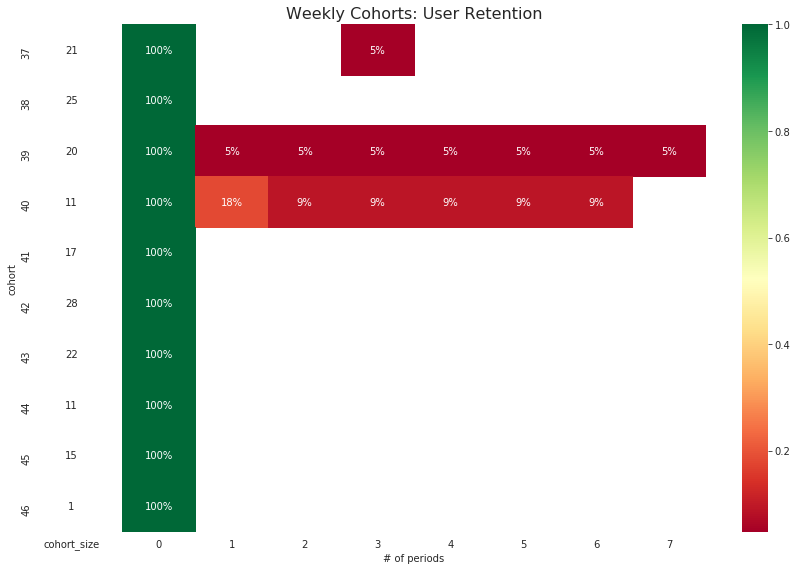

In [14]:
retention_matrix, cohort_size = create_cohorts(dfActivities, interval='week', offset=37)
plot_cohorts(retention_matrix, cohort_size)

## Monthly Retention

/Users/guilherme/.conda/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/guilherme/.conda/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


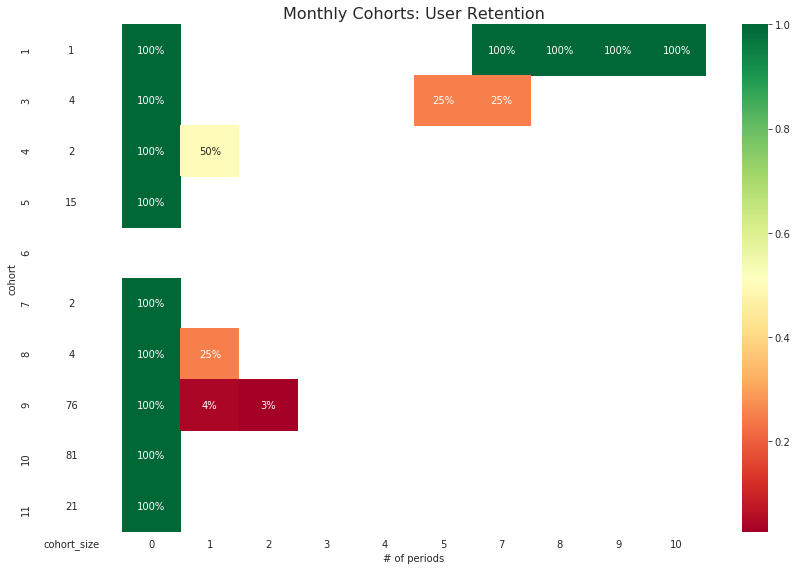

In [15]:
retention_matrix, cohort_size = create_cohorts(dfActivities, interval='month')
plot_cohorts(retention_matrix, cohort_size, title='Monthly Cohorts: User Retention')

/Users/guilherme/.conda/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/guilherme/.conda/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


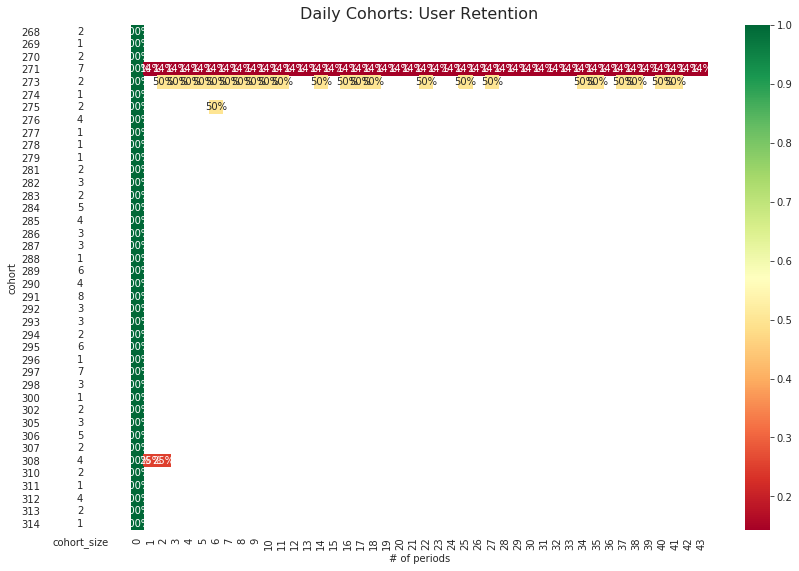

In [16]:
retention_matrix, cohort_size = create_cohorts(dfActivities, interval='day', offset=268)
plot_cohorts(retention_matrix, cohort_size, title='Daily Cohorts: User Retention')

# Summary

In [17]:
message = ''
message += acquisition_pipeline_metrics(dfUsers, dfActivities)
message += engagement_metrics(dfActivities)
message += growth_metrics(dfActivities, db)
message += retention_metrics(dfActivities)

print(message)


------ SIGNIN ---- 
70% of the users who triggered the pin actually signed up
10% diff from past 28 days

------ ONBOARDING ----
50% of the users signin in the platform and dont perform any action
46% diff from past 28 days

29% of the users signin in the platform create products
7% diff from past 28 days

14% of the users signin in the platform create orders
3% diff from past 28 days

2% of the users signin in the platform create supplier
-0% diff from past 28 days

2% of the users signin in the platform create purchase
1% diff from past 28 days

4% of the users signin in the platform create customer
-2% diff from past 28 days

------ ENGAGEMENT ----
6.285714285714286 mean in minutes that new users stay in the platform
129% diff from past 28 days

----- GROWTH METRICS -----
churn_d28 - 55 60 9%
churn_d7 - 10 14 40%
churn_d1 - 5 4 -20%
ACTIVE USERS: 5

------ RETENTION ----
d0: 72 80 11%
d1: 1 1 0%
d7: 3 1 -67%
d28: 2 0 -100%

d1/d0: 0.0125
d7/d1: 1.0
d28/d7: 0.0
d84/d28: 0
d364/d84: 